# Import Libraries

In [ ]:
from os import path


import pandas as pd
import numpy as np


# Split data and hyperparameter tuning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, RocCurveDisplay 

# Save models in .pkl format
from joblib import dump


import matplotlib.pyplot as plt
import seaborn as sns

# Load Datasets

In [2]:
df_pca = pd.read_csv(path.join("..", "data", "heart_disease_pca.csv"))
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,num
0,-1.087992,0.372638,1.271275,-0.240135,0.576431,0.856537,0.603891,-0.614801,-0.541453,0.245773,0.736680,0.686322,-0.640268,0.368900,0
1,-2.813771,0.807979,-0.120024,-0.558623,-0.570164,-0.825947,0.571407,0.003537,-0.490289,0.185441,0.161555,-0.754878,-0.485284,-0.437692,2
2,-2.329030,-1.089585,-0.474496,-0.027767,0.031975,1.028541,0.443364,0.631092,0.359245,0.250978,0.287731,0.055109,0.039899,0.056094,1
3,1.163143,-0.662409,1.579279,2.340236,1.617635,0.380933,-0.506575,-0.384098,-0.565434,-0.351726,0.162886,-0.532354,-0.092187,-0.393656,0
4,1.749042,-0.197127,0.929031,0.555730,0.824813,-0.459967,0.946655,0.539861,-0.350032,0.043926,-0.498762,0.214697,0.208312,0.900747,0


In [3]:
df_selected = pd.read_csv(path.join("..", "data", "heart_disease_selected_features.csv"))
df_selected.head()

,age,cp_asymptomatic,trestbps,chol,thalach,exang_yes,oldpeak,slope_upsloping,slope_flat,ca_0,ca_2,ca_3,thal_normal,thal_reversible_defect,num
0,0.936181,0.0,0.750380,-0.276443,0.017494,0.0,1.068965,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,1.378929,1.0,1.596266,0.744555,-1.816334,1.0,0.381773,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2
2,1.378929,1.0,-0.659431,-0.353500,-0.899420,1.0,1.326662,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1
3,-1.941680,0.0,-0.095506,0.051047,1.633010,0.0,2.099753,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4,-1.498933,0.0,-0.095506,-0.835103,0.978071,0.0,0.295874,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0


# Separate Features and Target and convert Target to Binary

In [4]:
X_pca = df_pca.drop("num", axis=1)
y = df_pca["num"]

X_selected = df_selected.drop("num", axis=1)

# Convert target to binary classification
y = y.apply(lambda x: 1 if x > 0 else 0)

# Split Data into Training and Testing Sets

In [5]:
# training (80%) and testing (20%) 
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

X_train_selected, X_test_selected, _, _ = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning

We will use RandomizedSearchCV with many iterations (50-100) first to explore a wide range of hyperparameters and discover which parameters ranges look promising, followed by GridSearchCV for fine-tuning. 

## Utility Functions and Variables

```python

### Parameters for Search

In [6]:
param_grid_lr = [
    {  # l2 penalty
        "penalty": ["l2"],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs", "liblinear", "saga"],
        "max_iter": [100, 200, 500]
    },
    {  # l1 penalty
        "penalty": ["l1"],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["liblinear", "saga"],
        "max_iter": [100, 200, 500]
    },
    {  # elasticnet penalty (needs l1_ratio)
        "penalty": ["elasticnet"],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["saga"],  # only saga supports elasticnet
        "l1_ratio": [0.1, 0.5, 0.9],  # must include this
        "max_iter": [100, 200, 500]
    },
    {  # no penalty (equivalent to OLS)
        "penalty": [None],
        "solver": ["lbfgs", "saga"],
        "max_iter": [100, 200, 500]
    }
]


param_grid_dt = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": [None, "sqrt", "log2"]
}


param_grid_rf = {
    "n_estimators": [100, 200, 500],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "class_weight": [None, "balanced"],
    "bootstrap": [True, False]
}


param_grid_svm = {
    "C": [0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    # only used for 'poly'
    "degree": [2, 3, 4],
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1]
}

### Evaluation and Save Functions and Variables

In [7]:
file_path = file_path = path.join("..", "results", "supervised_tuned__models_evaluation.txt")

models_names = [
    "Logistic Regression (PCA)",
    "Logistic Regression (Selected Features)",
    "Decision Tree (PCA)",
    "Decision Tree (Selected Features)",
    "Random Forest (PCA)",
    "Random Forest (Selected Features)",
    "SVM (PCA)",
    "SVM (Selected Features)"
]

In [8]:
def save_evaluation(model_name, best_params, metrics, report, file_path, mode):
    with open(file_path, mode) as f:
        f.write(f"{model_name}:\n\n")
        f.write(f"Best Hyperparameters: {best_params}\n")
        for metric_name, value in metrics.items():
            f.write(f"{metric_name}: {value:.4f}\n")
        f.write("Classification Report:\n")
        f.write(report)
        f.write("\n" + "="*85 + "\n\n")

In [9]:
def evaluate_model(y_true, y_pred, y_pred_proba, best_params, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    report = classification_report(y_true, y_pred, zero_division=0)

    print(f"Model: {model_name}\n")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(report)

    # save metrics to a text file
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }
    mode = 'a' if model_name != "Logistic Regression RandomizedSearchCV (PCA)" else 'w'
    save_evaluation(model_name, best_params, metrics, report, file_path, mode)

    return [accuracy, precision, recall, f1, roc_auc]

### Search Functions

In [10]:
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}
refit = 'roc_auc'

In [11]:
def random_search_cv(model, param_grid, X_train, y_train, n_iter=100, cv=10):
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=n_iter, cv=cv, scoring=scoring, refit=refit, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_


def grid_search_cv(model, param_grid, X_train, y_train, cv=10):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

## Apply Hyperparameter Tuning

### Logistic Regression

In [12]:
results = []
# Logistic Regression with PCA
lr_model_random_pca = LogisticRegression(random_state=42)
best_lr_random_pca, best_params_lr_random_pca = random_search_cv(lr_model_random_pca, param_grid_lr, X_train_pca, y_train)
print(f"Best parameters for Logistic Regression RandomizedSearchCV (PCA): {best_params_lr_random_pca}\n")
y_pred_lr_random_pca = best_lr_random_pca.predict(X_test_pca)
y_pred_proba_lr_random_pca = best_lr_random_pca.predict_proba(X_test_pca)[:, 1]
metrics_lr_random_pca = evaluate_model(y_test, y_pred_lr_random_pca, y_pred_proba_lr_random_pca, best_params_lr_random_pca, "Logistic Regression RandomizedSearchCV (PCA)")
results.append(["Logistic Regression RandomizedSearchCV (PCA)"] + metrics_lr_random_pca)


Best parameters for Logistic Regression RandomizedSearchCV (PCA): {'solver': 'saga', 'penalty': 'l1', 'max_iter': 500, 'C': 1}

Model: Logistic Regression RandomizedSearchCV (PCA)

Accuracy: 0.8333
Precision: 0.7333
Recall: 0.9167
F1 Score: 0.8148
ROC AUC: 0.9387
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        36
           1       0.73      0.92      0.81        24

    accuracy                           0.83        60
   macro avg       0.83      0.85      0.83        60
weighted avg       0.85      0.83      0.84        60



In [13]:
lr_model_random_selected = LogisticRegression(random_state=42)
best_lr_random_selected, best_params_lr_random_selected = random_search_cv(lr_model_random_selected, param_grid_lr, X_train_selected, y_train)
print(f"Best parameters for Logistic Regression RandomizedSearchCV (Selected Features): {best_params_lr_random_selected}\n")
y_pred_lr_random_selected = best_lr_random_selected.predict(X_test_selected)
y_pred_proba_lr_random_selected = best_lr_random_selected.predict_proba(X_test_selected)[:, 1]
metrics_lr_random_selected = evaluate_model(y_test, y_pred_lr_random_selected, y_pred_proba_lr_random_selected, best_params_lr_random_selected, "Logistic Regression RandomizedSearchCV (Selected Features)")
results.append(["Logistic Regression RandomizedSearchCV (Selected Features)"] + metrics_lr_random_selected)

Best parameters for Logistic Regression RandomizedSearchCV (Selected Features): {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 500, 'C': 1}

Model: Logistic Regression RandomizedSearchCV (Selected Features)

Accuracy: 0.8333
Precision: 0.7500
Recall: 0.8750
F1 Score: 0.8077
ROC AUC: 0.9398
              precision    recall  f1-score   support

           0       0.91      0.81      0.85        36
           1       0.75      0.88      0.81        24

    accuracy                           0.83        60
   macro avg       0.83      0.84      0.83        60
weighted avg       0.84      0.83      0.83        60



In [14]:
lr_model_grid_pca = LogisticRegression(random_state=42)
best_lr_grid_pca, best_params_lr_grid_pca = grid_search_cv(lr_model_grid_pca, param_grid_lr, X_train_pca, y_train)
print(f"Best parameters for Logistic Regression GridSearchCV (PCA): {best_params_lr_grid_pca}\n")
y_pred_lr_grid_pca = best_lr_grid_pca.predict(X_test_pca)
y_pred_proba_lr_grid_pca = best_lr_grid_pca.predict_proba(X_test_pca)[:, 1]
metrics_lr_grid_pca = evaluate_model(y_test, y_pred_lr_grid_pca, y_pred_proba_lr_grid_pca, best_params_lr_grid_pca, "Logistic Regression GridSearchCV (PCA)")
results.append(["Logistic Regression GridSearchCV (PCA)"] + metrics_lr_grid_pca)

Best parameters for Logistic Regression GridSearchCV (PCA): {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

Model: Logistic Regression GridSearchCV (PCA)

Accuracy: 0.8333
Precision: 0.7333
Recall: 0.9167
F1 Score: 0.8148
ROC AUC: 0.9387
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        36
           1       0.73      0.92      0.81        24

    accuracy                           0.83        60
   macro avg       0.83      0.85      0.83        60
weighted avg       0.85      0.83      0.84        60



In [15]:
lr_model_grid_selected = LogisticRegression(random_state=42)
best_lr_grid_selected, best_params_lr_grid_selected = grid_search_cv(lr_model_grid_selected, param_grid_lr, X_train_selected, y_train)
print(f"Best parameters for Logistic Regression GridSearchCV (Selected Features): {best_params_lr_grid_selected}\n")
y_pred_lr_grid_selected = best_lr_grid_selected.predict(X_test_selected)
y_pred_proba_lr_grid_selected = best_lr_grid_selected.predict_proba(X_test_selected)[:, 1]
metrics_lr_grid_selected = evaluate_model(y_test, y_pred_lr_grid_selected, y_pred_proba_lr_grid_selected, best_params_lr_grid_selected, "Logistic Regression GridSearchCV (Selected Features)")
results.append(["Logistic Regression GridSearchCV (Selected Features)"] + metrics_lr_grid_selected)

Best parameters for Logistic Regression GridSearchCV (Selected Features): {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

Model: Logistic Regression GridSearchCV (Selected Features)

Accuracy: 0.8333
Precision: 0.7500
Recall: 0.8750
F1 Score: 0.8077
ROC AUC: 0.9398
              precision    recall  f1-score   support

           0       0.91      0.81      0.85        36
           1       0.75      0.88      0.81        24

    accuracy                           0.83        60
   macro avg       0.83      0.84      0.83        60
weighted avg       0.84      0.83      0.83        60



### Decision Tree

In [16]:
dt_model_random_pca = DecisionTreeClassifier(random_state=42)
best_dt_random_pca, best_params_dt_random_pca = random_search_cv(dt_model_random_pca, param_grid_dt, X_train_pca, y_train)
print(f"Best parameters for Decision Tree RandomizedSearchCV (PCA): {best_params_dt_random_pca}\n")
y_pred_dt_random_pca = best_dt_random_pca.predict(X_test_pca)
y_pred_proba_dt_random_pca = best_dt_random_pca.predict_proba(X_test_pca)[:, 1]
metrics_dt_random_pca = evaluate_model(y_test, y_pred_dt_random_pca, y_pred_proba_dt_random_pca, best_params_dt_random_pca, "Decision Tree RandomizedSearchCV (PCA)")
results.append(["Decision Tree RandomizedSearchCV (PCA)"] + metrics_dt_random_pca)

Best parameters for Decision Tree RandomizedSearchCV (PCA): {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 30, 'criterion': 'entropy'}

Model: Decision Tree RandomizedSearchCV (PCA)

Accuracy: 0.8000
Precision: 0.7143
Recall: 0.8333
F1 Score: 0.7692
ROC AUC: 0.8200
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        36
           1       0.71      0.83      0.77        24

    accuracy                           0.80        60
   macro avg       0.79      0.81      0.80        60
weighted avg       0.81      0.80      0.80        60



In [17]:
dt_model_ramdom_selected = DecisionTreeClassifier(random_state=42)
best_dt_random_selected, best_params_dt_random_selected = random_search_cv(dt_model_ramdom_selected, param_grid_dt, X_train_selected, y_train)
print(f"Best parameters for Decision Tree RandomizedSearchCV (Selected Features): {best_params_dt_random_selected}\n")
y_pred_dt_random_selected = best_dt_random_selected.predict(X_test_selected)
y_pred_proba_dt_random_selected = best_dt_random_selected.predict_proba(X_test_selected)[:, 1]
metrics_dt_random_selected = evaluate_model(y_test, y_pred_dt_random_selected, y_pred_proba_dt_random_selected, best_params_dt_random_selected, "Decision Tree RandomizedSearchCV (Selected Features)")
results.append(["Decision Tree RandomizedSearchCV (Selected Features)"] + metrics_dt_random_selected)

Best parameters for Decision Tree RandomizedSearchCV (Selected Features): {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini'}

Model: Decision Tree RandomizedSearchCV (Selected Features)

Accuracy: 0.7667
Precision: 0.7273
Recall: 0.6667
F1 Score: 0.6957
ROC AUC: 0.7899
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        36
           1       0.73      0.67      0.70        24

    accuracy                           0.77        60
   macro avg       0.76      0.75      0.75        60
weighted avg       0.76      0.77      0.76        60



In [18]:
dt_model_grid_pca = DecisionTreeClassifier(random_state=42)
best_dt_grid_pca, best_params_dt_grid_pca = grid_search_cv(dt_model_grid_pca, param_grid_dt, X_train_pca, y_train)
print(f"Best parameters for Decision Tree GridSearchCV (PCA): {best_params_dt_grid_pca}\n")
y_pred_dt_grid_pca = best_dt_grid_pca.predict(X_test_pca)
y_pred_proba_dt_grid_pca = best_dt_grid_pca.predict_proba(X_test_pca)[:, 1]
metrics_dt_grid_pca = evaluate_model(y_test, y_pred_dt_grid_pca, y_pred_proba_dt_grid_pca, best_params_dt_grid_pca, "Decision Tree GridSearchCV (PCA)")
results.append(["Decision Tree GridSearchCV (PCA)"] + metrics_dt_grid_pca)

Best parameters for Decision Tree GridSearchCV (PCA): {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model: Decision Tree GridSearchCV (PCA)

Accuracy: 0.8000
Precision: 0.7143
Recall: 0.8333
F1 Score: 0.7692
ROC AUC: 0.8200
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        36
           1       0.71      0.83      0.77        24

    accuracy                           0.80        60
   macro avg       0.79      0.81      0.80        60
weighted avg       0.81      0.80      0.80        60



In [19]:
dt_model_grid_selected = DecisionTreeClassifier(random_state=42)
best_dt_grid_selected, best_params_dt_grid_selected = grid_search_cv(dt_model_grid_selected, param_grid_dt, X_train_selected, y_train)
print(f"Best parameters for Decision Tree GridSearchCV (Selected Features): {best_params_dt_grid_selected}\n")
y_pred_dt_grid_selected = best_dt_grid_selected.predict(X_test_selected)
y_pred_proba_dt_grid_selected = best_dt_grid_selected.predict_proba(X_test_selected)[:, 1]
metrics_dt_grid_selected = evaluate_model(y_test, y_pred_dt_grid_selected, y_pred_proba_dt_grid_selected, best_params_dt_grid_selected, "Decision Tree GridSearchCV (Selected Features)")
results.append(["Decision Tree GridSearchCV (Selected Features)"] + metrics_dt_grid_selected)

Best parameters for Decision Tree GridSearchCV (Selected Features): {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}

Model: Decision Tree GridSearchCV (Selected Features)

Accuracy: 0.8000
Precision: 0.7500
Recall: 0.7500
F1 Score: 0.7500
ROC AUC: 0.8958
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        36
           1       0.75      0.75      0.75        24

    accuracy                           0.80        60
   macro avg       0.79      0.79      0.79        60
weighted avg       0.80      0.80      0.80        60



### Random Forest

In [20]:
rf_model_random_pca = RandomForestClassifier(random_state=42)
best_rf_random_pca, best_params_rf_random_pca = random_search_cv(rf_model_random_pca, param_grid_rf, X_train_pca, y_train)
print(f"Best parameters for Random Forest RandomizedSearchCV (PCA): {best_params_rf_random_pca}\n")
y_pred_rf_random_pca = best_rf_random_pca.predict(X_test_pca)
y_pred_proba_rf_random_pca = best_rf_random_pca.predict_proba(X_test_pca)[:, 1]
metrics_rf_random_pca = evaluate_model(y_test, y_pred_rf_random_pca, y_pred_proba_rf_random_pca, best_params_rf_random_pca, "Random Forest RandomizedSearchCV (PCA)")
results.append(["Random Forest RandomizedSearchCV (PCA)"] + metrics_rf_random_pca)

Best parameters for Random Forest RandomizedSearchCV (PCA): {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Model: Random Forest RandomizedSearchCV (PCA)

Accuracy: 0.8167
Precision: 0.7407
Recall: 0.8333
F1 Score: 0.7843
ROC AUC: 0.9259
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        36
           1       0.74      0.83      0.78        24

    accuracy                           0.82        60
   macro avg       0.81      0.82      0.81        60
weighted avg       0.82      0.82      0.82        60



In [21]:
rf_model_random_selected = RandomForestClassifier(random_state=42)
best_rf_random_selected, best_params_rf_random_selected = random_search_cv(rf_model_random_selected, param_grid_rf, X_train_selected, y_train)
print(f"Best parameters for Random Forest RandomizedSearchCV (Selected Features): {best_params_rf_random_selected}\n")
y_pred_rf_random_selected = best_rf_random_selected.predict(X_test_selected)
y_pred_proba_rf_random_selected = best_rf_random_selected.predict_proba(X_test_selected)[:, 1]
metrics_rf_random_selected = evaluate_model(y_test, y_pred_rf_random_selected, y_pred_proba_rf_random_selected, best_params_rf_random_selected, "Random Forest RandomizedSearchCV (Selected Features)")
results.append(["Random Forest RandomizedSearchCV (Selected Features)"] + metrics_rf_random_selected)

Best parameters for Random Forest RandomizedSearchCV (Selected Features): {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}

Model: Random Forest RandomizedSearchCV (Selected Features)

Accuracy: 0.8500
Precision: 0.8000
Recall: 0.8333
F1 Score: 0.8163
ROC AUC: 0.9502
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        36
           1       0.80      0.83      0.82        24

    accuracy                           0.85        60
   macro avg       0.84      0.85      0.84        60
weighted avg       0.85      0.85      0.85        60



In [22]:
# Random Forest GridSearchCV takes longer time to finish, so we will use a refined parameter grid based on the best parameters from RandomizedSearchCV
refined_param_grid_rf_pca = {
    "n_estimators": [200, 400, 500],
    "criterion": ["gini"],
    "max_depth": [20, 30, 40],
    "min_samples_split": [10, 20, 30],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["log2"],
    "class_weight": [None],
    "bootstrap": [True]
}

rf_model_grid_pca = RandomForestClassifier(random_state=42)
best_rf_grid_pca, best_params_rf_grid_pca = grid_search_cv(rf_model_grid_pca, refined_param_grid_rf_pca, X_train_pca, y_train)
print(f"Best parameters for Random Forest GridSearchCV (PCA): {best_params_rf_grid_pca}\n")
y_pred_rf_grid_pca = best_rf_grid_pca.predict(X_test_pca)
y_pred_proba_rf_grid_pca = best_rf_grid_pca.predict_proba(X_test_pca)[:, 1]
metrics_rf_grid_pca = evaluate_model(y_test, y_pred_rf_grid_pca, y_pred_proba_rf_grid_pca, best_params_rf_grid_pca, "Random Forest GridSearchCV (PCA)")
results.append(["Random Forest GridSearchCV (PCA)"] + metrics_rf_grid_pca)


Best parameters for Random Forest GridSearchCV (PCA): {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

Model: Random Forest GridSearchCV (PCA)

Accuracy: 0.8167
Precision: 0.7407
Recall: 0.8333
F1 Score: 0.7843
ROC AUC: 0.9259
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        36
           1       0.74      0.83      0.78        24

    accuracy                           0.82        60
   macro avg       0.81      0.82      0.81        60
weighted avg       0.82      0.82      0.82        60



In [23]:
refined_param_grid_rf_selected = {
    "n_estimators": [200, 400, 500],
    "criterion": ["entropy"],
    "max_depth": [20, 30, 40],
    "min_samples_split": [10, 20, 30],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt"],
    "class_weight": ["balanced"],
    "bootstrap": [True]
}

rf_model_grid_selected = RandomForestClassifier(random_state=42)
best_rf_grid_selected, best_params_rf_grid_selected = grid_search_cv(rf_model_grid_selected, refined_param_grid_rf_selected, X_train_selected, y_train)
print(f"Best parameters for Random Forest GridSearchCV (Selected Features): {best_params_rf_grid_selected}\n")
y_pred_rf_grid_selected = best_rf_grid_selected.predict(X_test_selected)
y_pred_proba_rf_grid_selected = best_rf_grid_selected.predict_proba(X_test_selected)[:, 1]
metrics_rf_grid_selected = evaluate_model(y_test, y_pred_rf_grid_selected, y_pred_proba_rf_grid_selected, best_params_rf_grid_selected, "Random Forest GridSearchCV (Selected Features)")
results.append(["Random Forest GridSearchCV (Selected Features)"] + metrics_rf_grid_selected)

Best parameters for Random Forest GridSearchCV (Selected Features): {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Model: Random Forest GridSearchCV (Selected Features)

Accuracy: 0.8500
Precision: 0.8000
Recall: 0.8333
F1 Score: 0.8163
ROC AUC: 0.9502
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        36
           1       0.80      0.83      0.82        24

    accuracy                           0.85        60
   macro avg       0.84      0.85      0.84        60
weighted avg       0.85      0.85      0.85        60



# SVM

In [24]:
svm_model_random_pca = SVC(probability=True, random_state=42)
best_svm_random_pca, best_params_svm_random_pca = random_search_cv(svm_model_random_pca, param_grid_svm, X_train_pca, y_train)
print(f"Best parameters for SVM RandomizedSearchCV (PCA): {best_params_svm_random_pca}\n")
y_pred_svm_random_pca = best_svm_random_pca.predict(X_test_pca)
y_pred_proba_svm_random_pca = best_svm_random_pca.predict_proba(X_test_pca)[:, 1]
metrics_svm_random_pca = evaluate_model(y_test, y_pred_svm_random_pca, y_pred_proba_svm_random_pca, best_params_svm_random_pca, "SVM RandomizedSearchCV (PCA)")
results.append(["SVM RandomizedSearchCV (PCA)"] + metrics_svm_random_pca)

Best parameters for SVM RandomizedSearchCV (PCA): {'kernel': 'linear', 'gamma': 'auto', 'degree': 4, 'C': 0.1}

Model: SVM RandomizedSearchCV (PCA)

Accuracy: 0.8667
Precision: 0.8077
Recall: 0.8750
F1 Score: 0.8400
ROC AUC: 0.9387
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        36
           1       0.81      0.88      0.84        24

    accuracy                           0.87        60
   macro avg       0.86      0.87      0.86        60
weighted avg       0.87      0.87      0.87        60



In [25]:
svm_model_random_selected = SVC(probability=True, random_state=42)
best_svm_random_selected, best_params_svm_random_selected = random_search_cv(svm_model_random_selected, param_grid_svm, X_train_selected, y_train)
print(f"Best parameters for SVM RandomizedSearchCV (Selected Features): {best_params_svm_random_selected}\n")
y_pred_svm_random_selected = best_svm_random_selected.predict(X_test_selected)
y_pred_proba_svm_random_selected = best_svm_random_selected.predict_proba(X_test_selected)[:, 1]
metrics_svm_random_selected = evaluate_model(y_test, y_pred_svm_random_selected, y_pred_proba_svm_random_selected, best_params_svm_random_selected, "SVM RandomizedSearchCV (Selected Features)")
results.append(["SVM RandomizedSearchCV (Selected Features)"] + metrics_svm_random_selected)

Best parameters for SVM RandomizedSearchCV (Selected Features): {'kernel': 'sigmoid', 'gamma': 0.1, 'degree': 4, 'C': 1}

Model: SVM RandomizedSearchCV (Selected Features)

Accuracy: 0.9000
Precision: 0.9091
Recall: 0.8333
F1 Score: 0.8696
ROC AUC: 0.9537
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        36
           1       0.91      0.83      0.87        24

    accuracy                           0.90        60
   macro avg       0.90      0.89      0.89        60
weighted avg       0.90      0.90      0.90        60



In [26]:
svm_model_grid_pca = SVC(probability=True, random_state=42)
best_svm_grid_pca, best_params_svm_grid_pca = grid_search_cv(svm_model_grid_pca, param_grid_svm, X_train_pca, y_train)
print(f"Best parameters for SVM GridSearchCV (PCA): {best_params_svm_grid_pca}\n")
y_pred_svm_grid_pca = best_svm_grid_pca.predict(X_test_pca)
y_pred_proba_svm_grid_pca = best_svm_grid_pca.predict_proba(X_test_pca)[:, 1]
metrics_svm_grid_pca = evaluate_model(y_test, y_pred_svm_grid_pca, y_pred_proba_svm_grid_pca, best_params_svm_grid_pca, "SVM GridSearchCV (PCA)")
results.append(["SVM GridSearchCV (PCA)"] + metrics_svm_grid_pca)

Best parameters for SVM GridSearchCV (PCA): {'C': 100, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}

Model: SVM GridSearchCV (PCA)

Accuracy: 0.8667
Precision: 0.7857
Recall: 0.9167
F1 Score: 0.8462
ROC AUC: 0.9306
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        36
           1       0.79      0.92      0.85        24

    accuracy                           0.87        60
   macro avg       0.86      0.88      0.86        60
weighted avg       0.88      0.87      0.87        60



In [27]:
svm_model_grid_selected = SVC(probability=True, random_state=42)
best_svm_grid_selected, best_params_svm_grid_selected = grid_search_cv(svm_model_grid_selected, param_grid_svm, X_train_selected, y_train)
print(f"Best parameters for SVM GridSearchCV (Selected Features): {best_params_svm_grid_selected}\n")
y_pred_svm_grid_selected = best_svm_grid_selected.predict(X_test_selected)
y_pred_proba_svm_grid_selected = best_svm_grid_selected.predict_proba(X_test_selected)[:, 1]
metrics_svm_grid_selected = evaluate_model(y_test, y_pred_svm_grid_selected, y_pred_proba_svm_grid_selected, best_params_svm_grid_selected, "SVM GridSearchCV (Selected Features)")
results.append(["SVM GridSearchCV (Selected Features)"] + metrics_svm_grid_selected)

Best parameters for SVM GridSearchCV (Selected Features): {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'sigmoid'}

Model: SVM GridSearchCV (Selected Features)

Accuracy: 0.9000
Precision: 0.9091
Recall: 0.8333
F1 Score: 0.8696
ROC AUC: 0.9537
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        36
           1       0.91      0.83      0.87        24

    accuracy                           0.90        60
   macro avg       0.90      0.89      0.89        60
weighted avg       0.90      0.90      0.90        60



In [28]:
columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
sort_metrics = ["ROC AUC", "Recall", "F1 Score", "Accuracy", "Precision"]

df_results = pd.DataFrame(results, columns=columns)

df_results = df_results.round(4)
df_results_sorted = df_results.sort_values(by=sort_metrics, ascending=False)
df_results_sorted

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
13,SVM RandomizedSearchCV (Selected Features),0.9000,0.9091,0.8333,0.8696,0.9537
15,SVM GridSearchCV (Selected Features),0.9000,0.9091,0.8333,0.8696,0.9537
9,Random Forest RandomizedSearchCV (Selected Fea...,0.8500,0.8000,0.8333,0.8163,0.9502
11,Random Forest GridSearchCV (Selected Features),0.8500,0.8000,0.8333,0.8163,0.9502
1,Logistic Regression RandomizedSearchCV (Select...,0.8333,0.7500,0.8750,0.8077,0.9398
3,Logistic Regression GridSearchCV (Selected Fea...,0.8333,0.7500,0.8750,0.8077,0.9398
0,Logistic Regression RandomizedSearchCV (PCA),0.8333,0.7333,0.9167,0.8148,0.9387
2,Logistic Regression GridSearchCV (PCA),0.8333,0.7333,0.9167,0.8148,0.9387
12,SVM RandomizedSearchCV (PCA),0.8667,0.8077,0.8750,0.8400,0.9387
14,SVM GridSearchCV (PCA),0.8667,0.7857,0.9167,0.8462,0.9306


In [29]:
# Save results to a text file
metrics_str = ', '.join(sort_metrics)

with open(file_path, 'a') as f:
    f.write(f"Summary of All Models sorted by {metrics_str} respectively:\n\n")
    f.write(df_results.to_string(index=False))
    f.write("\n")

# ROC Curves

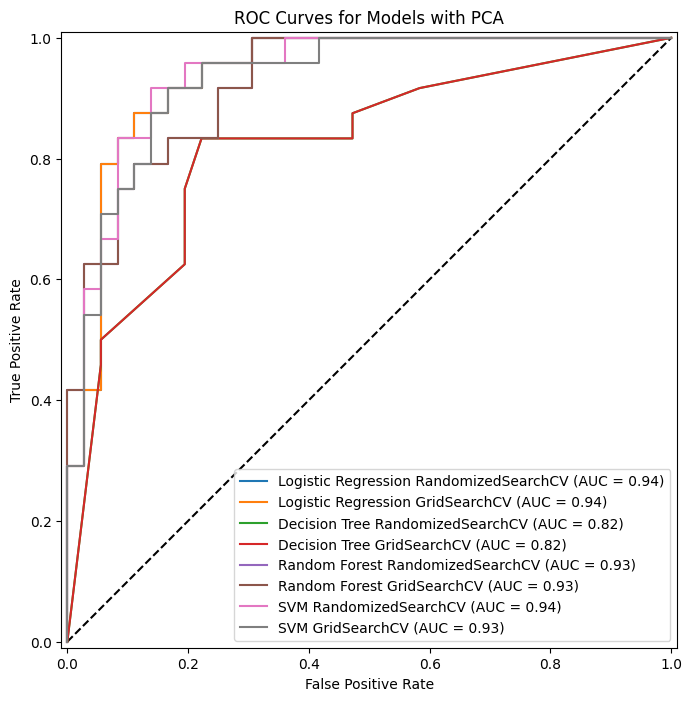

In [30]:
plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
RocCurveDisplay.from_predictions(y_test, y_pred_proba_lr_random_pca, name="Logistic Regression RandomizedSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_lr_grid_pca, name="Logistic Regression GridSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_dt_random_pca, name="Decision Tree RandomizedSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_dt_grid_pca, name="Decision Tree GridSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_rf_random_pca, name="Random Forest RandomizedSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_rf_grid_pca, name="Random Forest GridSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_svm_random_pca, name="SVM RandomizedSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_svm_grid_pca, name="SVM GridSearchCV", ax=plt.gca())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models with PCA')
plt.legend()
plt.show()

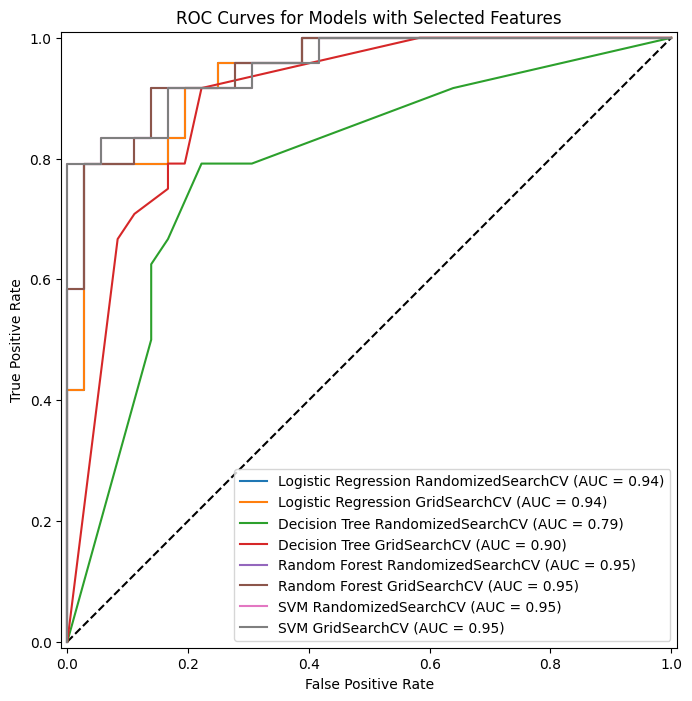

In [31]:
plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
RocCurveDisplay.from_predictions(y_test, y_pred_proba_lr_random_selected, name="Logistic Regression RandomizedSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_lr_grid_selected, name="Logistic Regression GridSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_dt_random_selected, name="Decision Tree RandomizedSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_dt_grid_selected, name="Decision Tree GridSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_rf_random_selected, name="Random Forest RandomizedSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_rf_grid_selected, name="Random Forest GridSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_svm_random_selected, name="SVM RandomizedSearchCV", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_pred_proba_svm_grid_selected, name="SVM GridSearchCV", ax=plt.gca())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models with Selected Features')
plt.legend()
plt.show()

# Compare optimized models with baseline performance.

## Load baseline results

In [32]:
baseline_file_path = path.join("..", "results", "supervised_baseline_models_evaluation.txt")
with open(baseline_file_path, 'r') as f:
    baseline_results = f.readlines()
baseline_results = [line.strip().split(": ")[1] for line in baseline_results if line.startswith("Accuracy") or line.startswith("Precision") or line.startswith("Recall") or line.startswith("F1 Score") or line.startswith("ROC AUC")]
baseline_metrics = [float(value) for value in baseline_results]
baseline_results

['0.8500',
 '0.7586',
 '0.9167',
 '0.8302',
 '0.9387',
 '0.8333',
 '0.7500',
 '0.8750',
 '0.8077',
 '0.9444',
 '0.7333',
 '0.6429',
 '0.7500',
 '0.6923',
 '0.7361',
 '0.8167',
 '0.7407',
 '0.8333',
 '0.7843',
 '0.8194',
 '0.8500',
 '0.8000',
 '0.8333',
 '0.8163',
 '0.9468',
 '0.8833',
 '0.8400',
 '0.8750',
 '0.8571',
 '0.9525',
 '0.9000',
 '0.8462',
 '0.9167',
 '0.8800',
 '0.9352',
 '0.8833',
 '0.8696',
 '0.8333',
 '0.8511',
 '0.9421']

## Convert Baseline Results to Dataframe

In [33]:

# reshape baseline into (n_models, 5 metrics)
baseline_array = np.array(baseline_results, dtype=float).reshape(-1, 5)

df_baseline = pd.DataFrame(
    baseline_array,
    columns=columns[1:]
)
df_baseline["Model"] = models_names
df_baseline = df_baseline[columns]
df_baseline

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression (PCA),0.8500,0.7586,0.9167,0.8302,0.9387
1,Logistic Regression (Selected Features),0.8333,0.7500,0.8750,0.8077,0.9444
2,Decision Tree (PCA),0.7333,0.6429,0.7500,0.6923,0.7361
3,Decision Tree (Selected Features),0.8167,0.7407,0.8333,0.7843,0.8194
4,Random Forest (PCA),0.8500,0.8000,0.8333,0.8163,0.9468
5,Random Forest (Selected Features),0.8833,0.8400,0.8750,0.8571,0.9525
6,SVM (PCA),0.9000,0.8462,0.9167,0.8800,0.9352
7,SVM (Selected Features),0.8833,0.8696,0.8333,0.8511,0.9421


## Merge baseline and optimized results for comparison

In [34]:
df_results_sorted["Type"] = "Tuned"
df_baseline["Type"] = "Baseline"

df_combined = pd.concat([df_results_sorted, df_baseline], ignore_index=True)

df_combined_sorted = df_combined.sort_values(by=sort_metrics, ascending=False)

df_combined_sorted

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Type
0,SVM RandomizedSearchCV (Selected Features),0.9000,0.9091,0.8333,0.8696,0.9537,Tuned
1,SVM GridSearchCV (Selected Features),0.9000,0.9091,0.8333,0.8696,0.9537,Tuned
21,Random Forest (Selected Features),0.8833,0.8400,0.8750,0.8571,0.9525,Baseline
2,Random Forest RandomizedSearchCV (Selected Fea...,0.8500,0.8000,0.8333,0.8163,0.9502,Tuned
3,Random Forest GridSearchCV (Selected Features),0.8500,0.8000,0.8333,0.8163,0.9502,Tuned
20,Random Forest (PCA),0.8500,0.8000,0.8333,0.8163,0.9468,Baseline
17,Logistic Regression (Selected Features),0.8333,0.7500,0.8750,0.8077,0.9444,Baseline
23,SVM (Selected Features),0.8833,0.8696,0.8333,0.8511,0.9421,Baseline
4,Logistic Regression RandomizedSearchCV (Select...,0.8333,0.7500,0.8750,0.8077,0.9398,Tuned
5,Logistic Regression GridSearchCV (Selected Fea...,0.8333,0.7500,0.8750,0.8077,0.9398,Tuned


## Best Models

Best overall model: SVM (Selected Features, Tuned).

Best PCA model: SVM (Baseline).

Best Selected Features model: SVM (Tuned).

# Save combined results and best models

In [35]:
# Save combined results to a text file
combined_file_path = path.join("..", "results", "supervised_combined_models_evaluation.txt")
with open(combined_file_path, 'w') as f:
    f.write(f"Combined Summary of Baseline and Tuned Models sorted by {metrics_str} respectively:\n\n")
    f.write(df_combined_sorted.to_string(index=False))
    f.write("\n")

In [36]:
# save best models results in text file
best_models_file_path = path.join("..", "results", "supervised_best_models_evaluation.txt")

best_overall = df_combined_sorted[
    (df_combined_sorted["Type"] == "Tuned") &
    (df_combined_sorted["Model"].str.contains("SVM")) &
    (df_combined_sorted["Model"].str.contains("Selected Features"))
] 
best_PCA = df_combined_sorted[df_combined_sorted["Model"] == "SVM (PCA)"]
best_selected = df_combined_sorted[
    (df_combined_sorted["Type"] == "Tuned") &
    (df_combined_sorted["Model"].str.contains("SVM")) &
    (df_combined_sorted["Model"].str.contains("Selected Features"))
]

with open(best_models_file_path, 'w') as f:
    f.write("Best Overall Models:\n\n")
    f.write(best_overall.to_string(index=False))
    f.write("\n\nBest PCA Model:\n\n")
    f.write(best_PCA.to_string(index=False))
    f.write("\n\nBest Selected Features Models:\n\n")
    f.write(best_selected.to_string(index=False))
    f.write("\n")


In [ ]:
# Save the best models using joblib
folder_path = path.join("..", "models")
dump(best_svm_grid_selected, path.join(folder_path, "best_overall_and_selected_features_svm_tuned.pkl"))

# As the best PCA model is baseline SVM and it is already saved, i will change the name to reflect that
from os import rename

rename(path.join(folder_path, "best_baseline_pca_model_svm.pkl"), path.join(folder_path, "best_pca_svm_baseline.pkl"))